# Market Mix Modelling Tango

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.express as px

# Load data:
with pd.ExcelFile("../data/raw/Data AA Graph.xlsx") as xlsx:
    omset_df = pd.read_excel(xlsx, "Omset")
    aa_graph_df = pd.read_excel(xlsx, "Data")

# Data Preprocessing

In [2]:
from itertools import product

# Constant 
START_DATE = '2015-01-01'
END_DATE = '2024-03-01'

# Preprocess Omset
def preprocess_omset(df):
    # 1. Create `Periode` column (%Y-%m-%d)
    df['Periode'] = pd.to_datetime(df['Thn'].astype(str) + '-' + df['Bln'].astype(str) + '-01')
    df = df.drop(columns=['Thn', 'Bln'])
    df['KP'] = df['KP'].str.upper()

    # 2. Groupby sum aggregation by `Periode` and `KP`
    df = df.groupby(by=['Periode', 'KP']).agg({'QtyKrt': 'sum', 'Rp': 'sum', 'EC': 'sum'}).reset_index()

    # 3. Filter to only use data until 01-04-2024
    df = df[df['Periode']<=END_DATE]

    # 4. Add zeros for missing values between '2015-01-01' and '2024-03-01'
    kp = df['KP'].unique()
    date_ranges = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')

    complete_date_df = pd.DataFrame(product(date_ranges, kp), columns=['Periode', 'KP'])
    df = complete_date_df.merge(df, how='left', on=['Periode', 'KP']).fillna(0)
    df = df.rename(columns={'QtyKrt': 'Sales'})

    return df

preprocessed_omset_df = preprocess_omset(omset_df.copy())

def preprocess_aa_graph(df):
    # 1. Drop column from `Wilayah`
    df = df.drop(columns=['Wilayah'])

    # 2. Rename column from `Product` to `KP`
    df = df.rename(columns={"Product": "KP"})

    # 3. Normalize string values
    for col in df.select_dtypes('object'):
        df[col] = df[col].str.upper()

    # 4. Change unit of scale from 'Puluhan Jt Rp' TO 'Jt Rupiah'
    def change_unit_scale(row):
        if re.match('.*(PULUHAN JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 10_000_000
            row['Dimensi'] = re.sub('PULUHAN JT RP', 'RP', row['Dimensi'])
        elif re.match('.*(JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 1_000_000
            row['Dimensi'] = re.sub('JT RP', 'RP', row['Dimensi'])
        return row
    df = df.apply(change_unit_scale, axis=1)

    # 5. Change inconsistensies of string in `Dimensi`
    df['Dimensi'] = df['Dimensi'].replace(to_replace=r'YG', value='YANG', regex=True)
    
    # 6. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]
    return df

preprocessed_aa_graph_df = preprocess_aa_graph(aa_graph_df.copy())

In [3]:
def get_data_by_kp(kp, omset_columns, aa_graph_columns):
    subset_omset_df = preprocessed_omset_df[preprocessed_omset_df['KP']==kp]
    subset_omset_df = subset_omset_df[omset_columns]
    subset_aa_graph_df= preprocessed_aa_graph_df[aa_graph_columns]
    df_with_exog = subset_omset_df.merge(subset_aa_graph_df, on=['KP', 'Periode'])
    df_with_exog = df_with_exog.pivot(index=['KP', 'Periode', 'Sales'], columns='Dimensi', values='Value').fillna(0).reset_index()
    df_with_exog = df_with_exog.rename_axis(None, axis=1)
    return df_with_exog

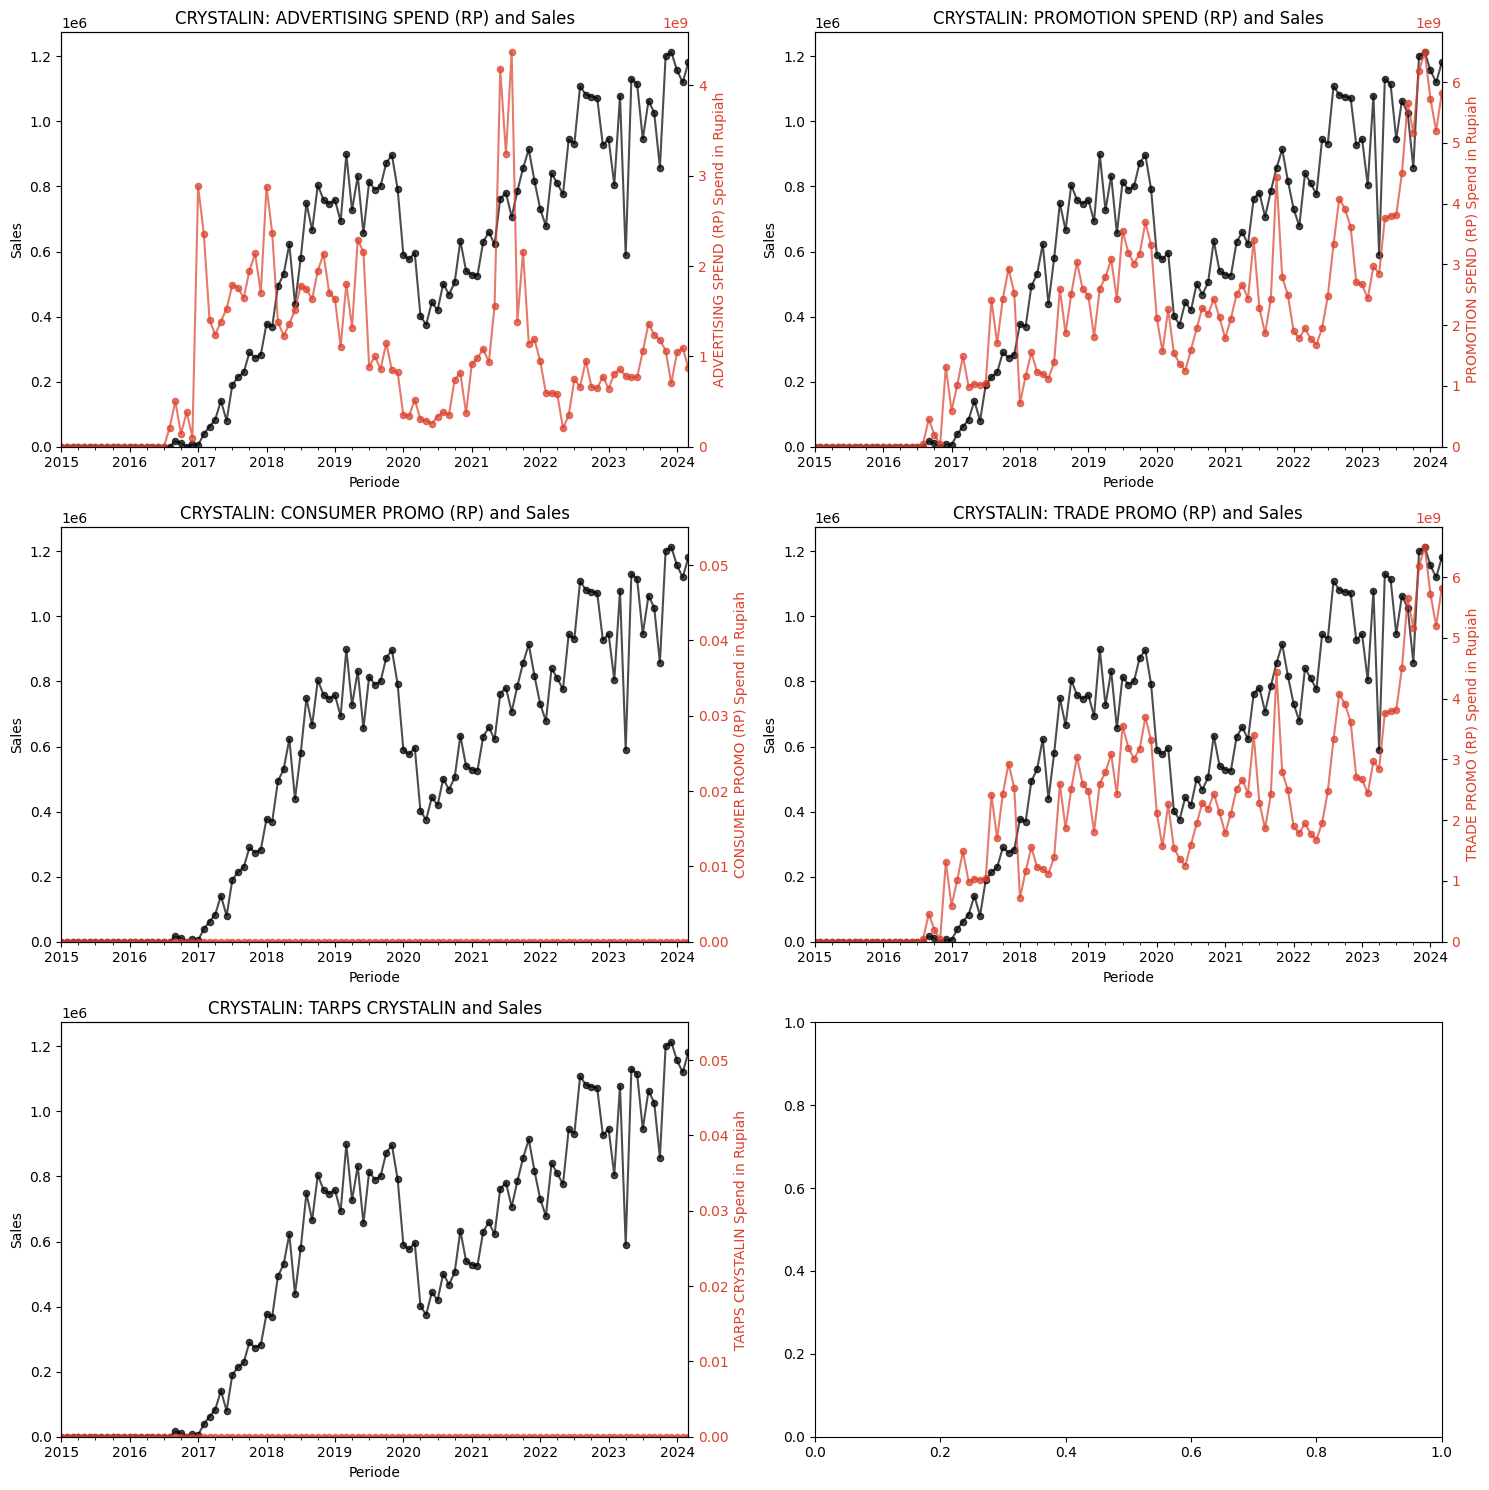

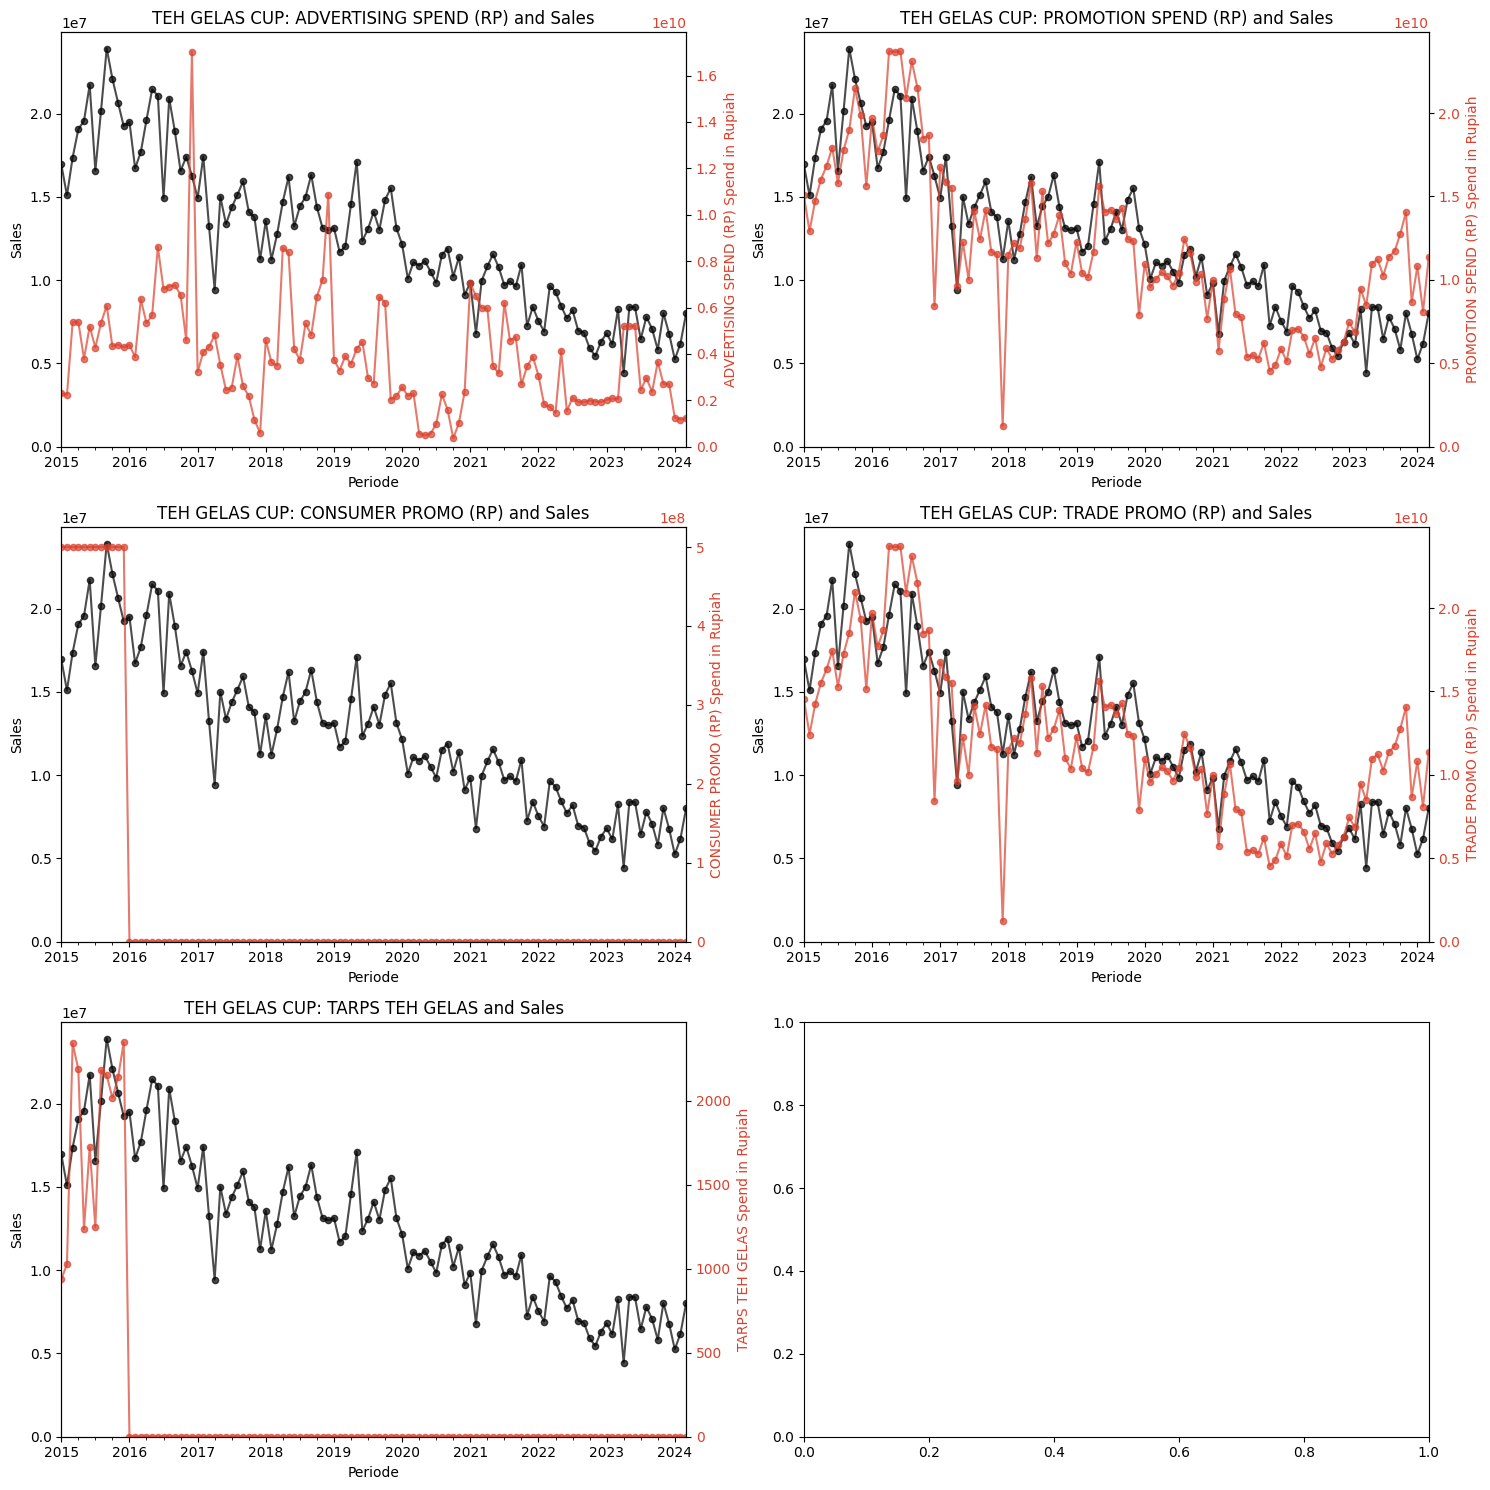

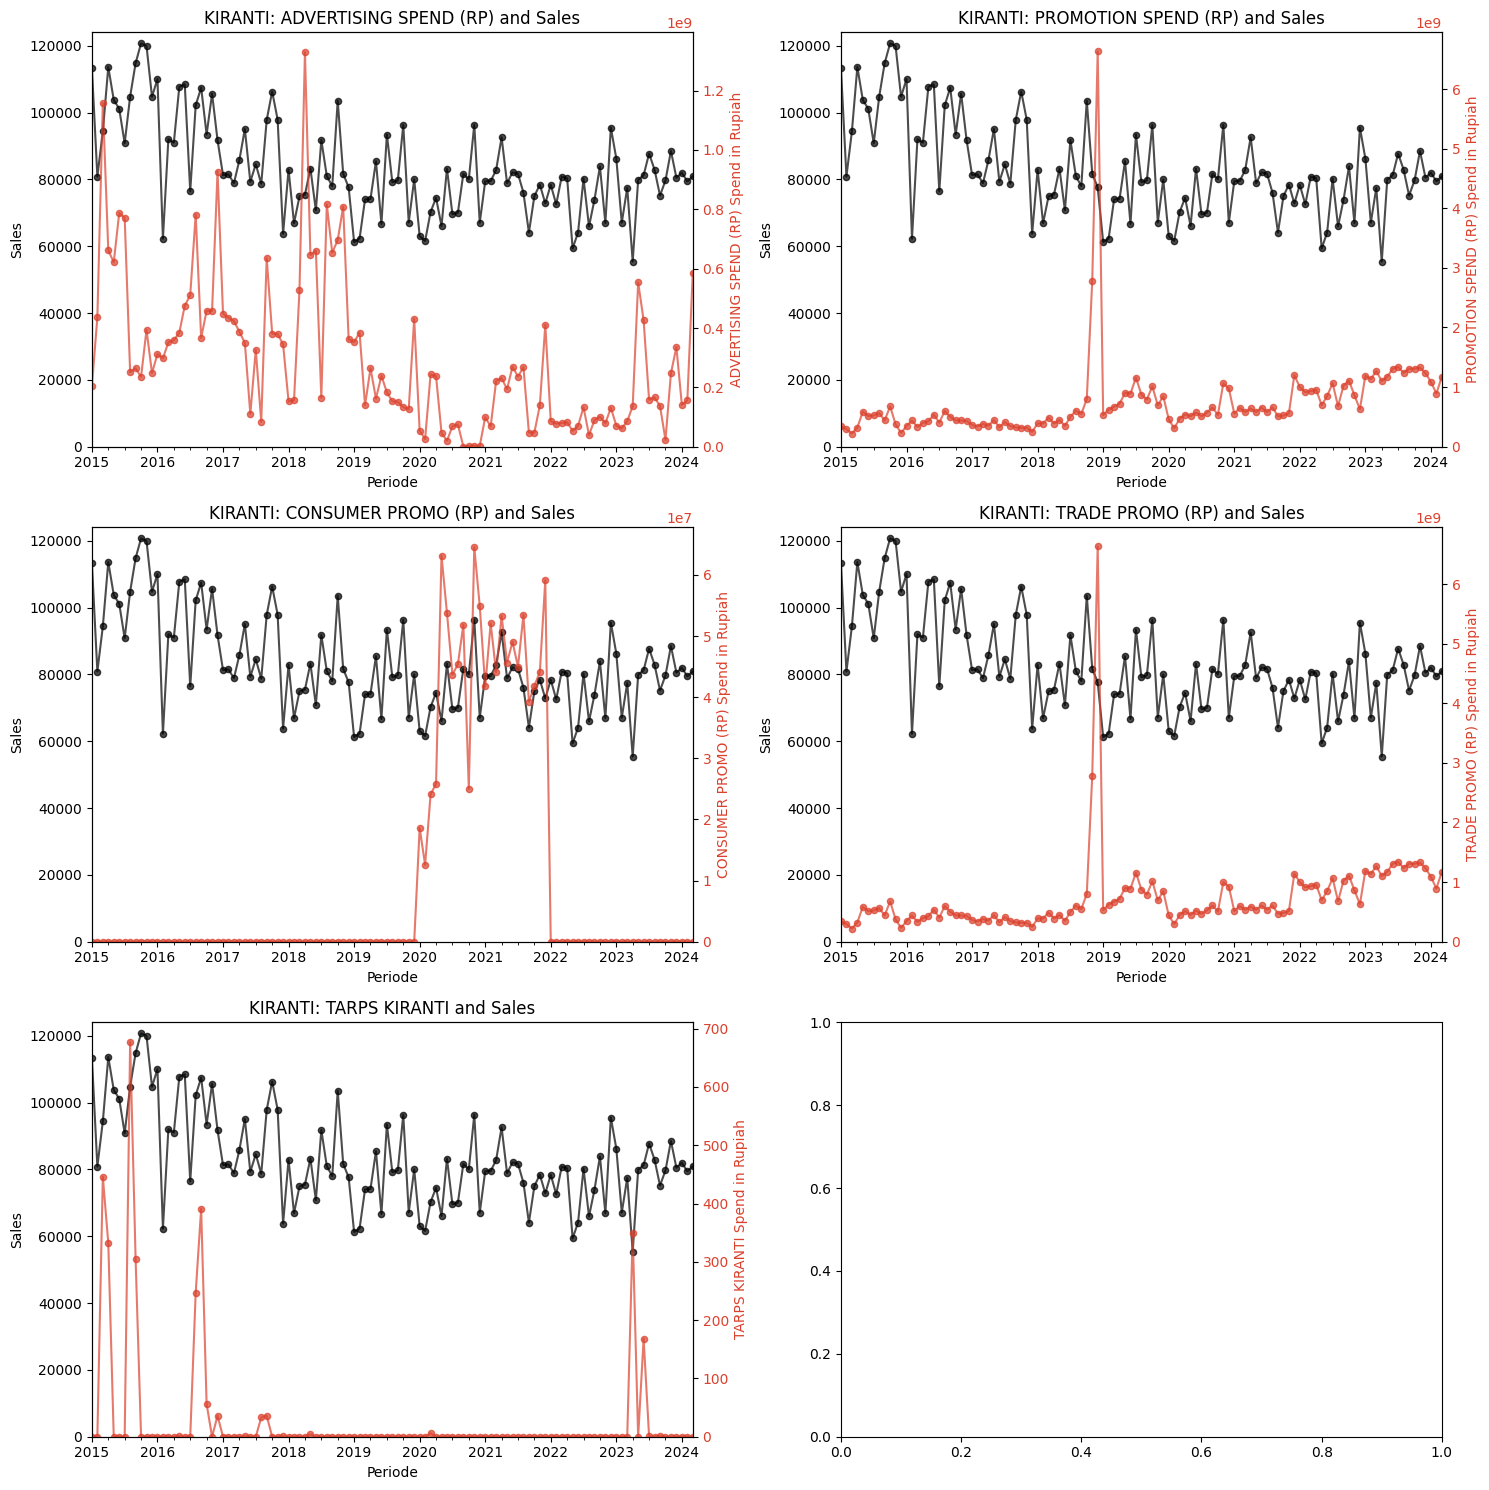

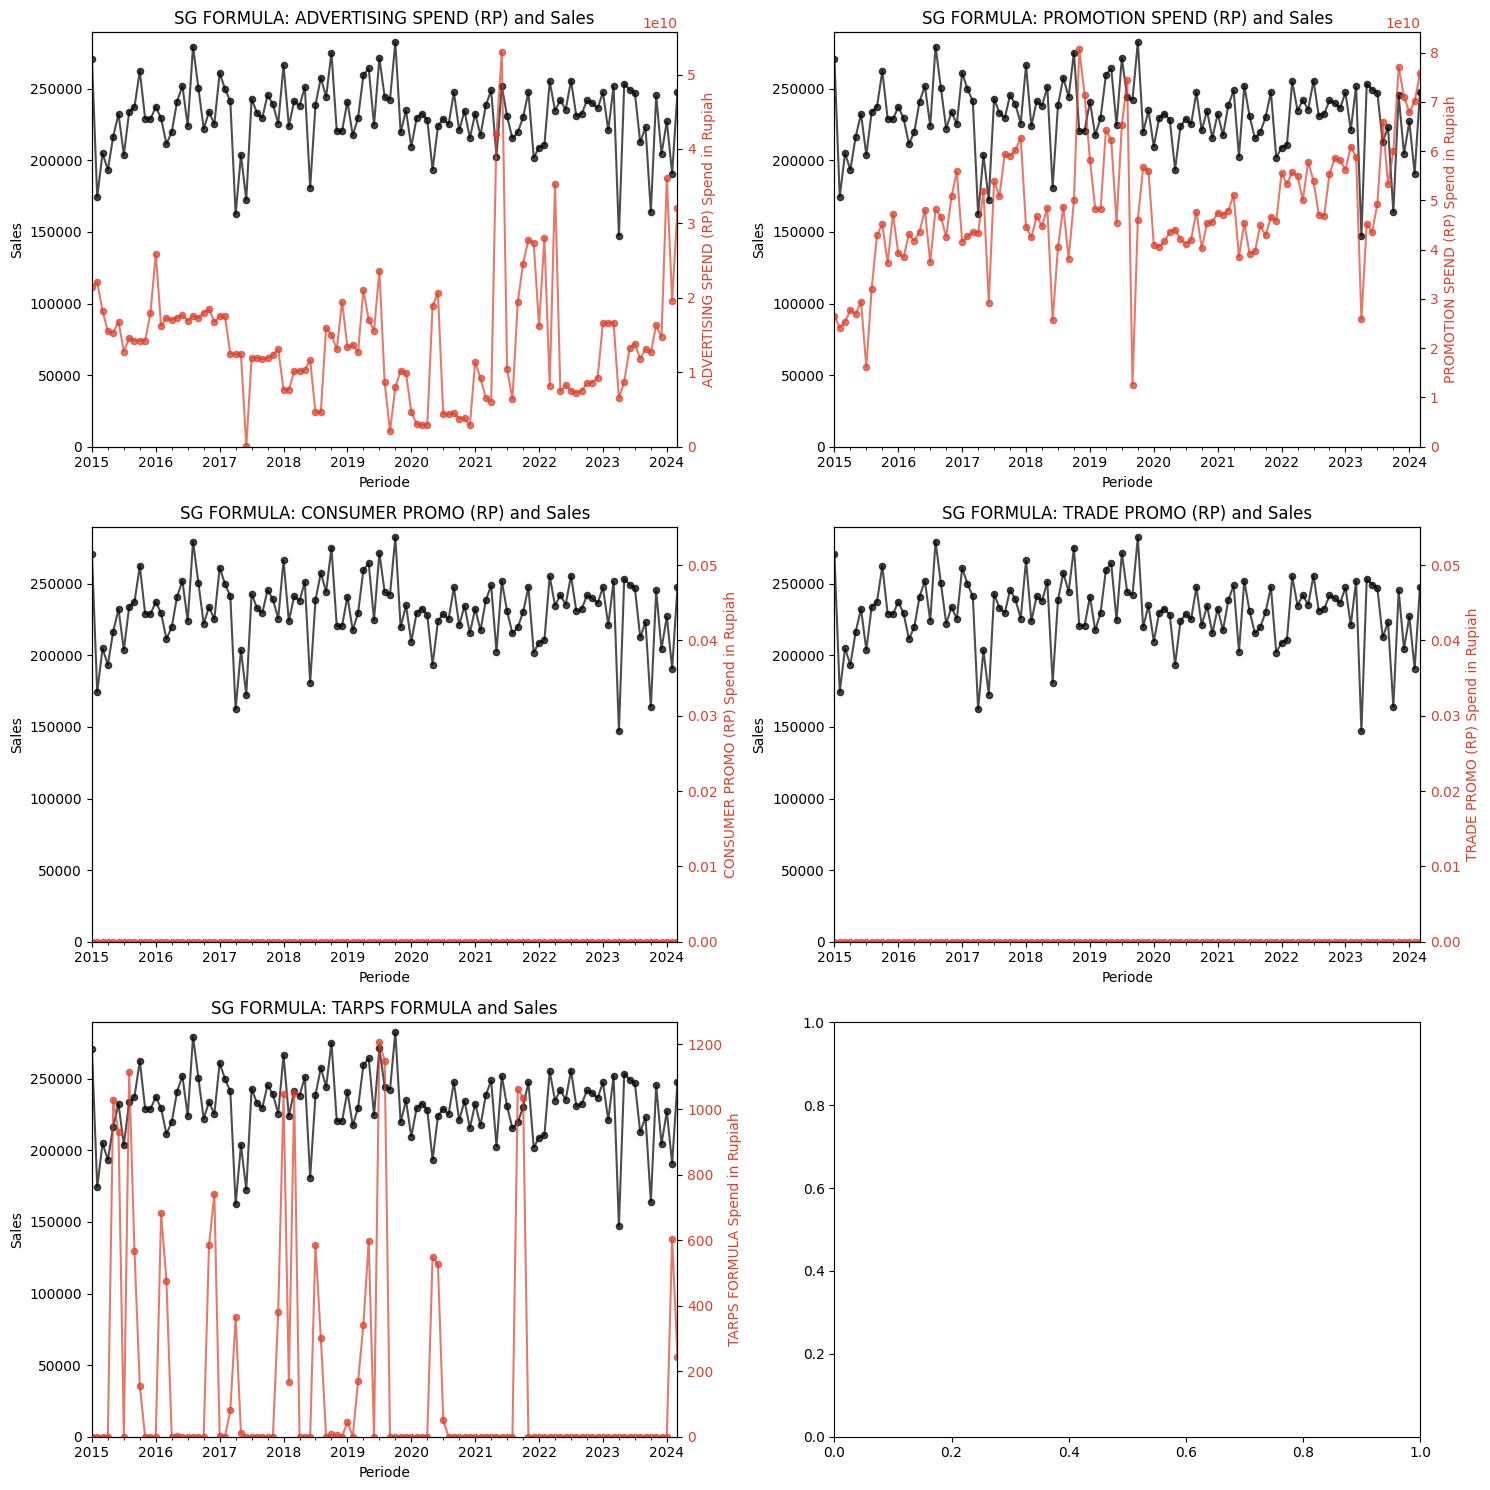

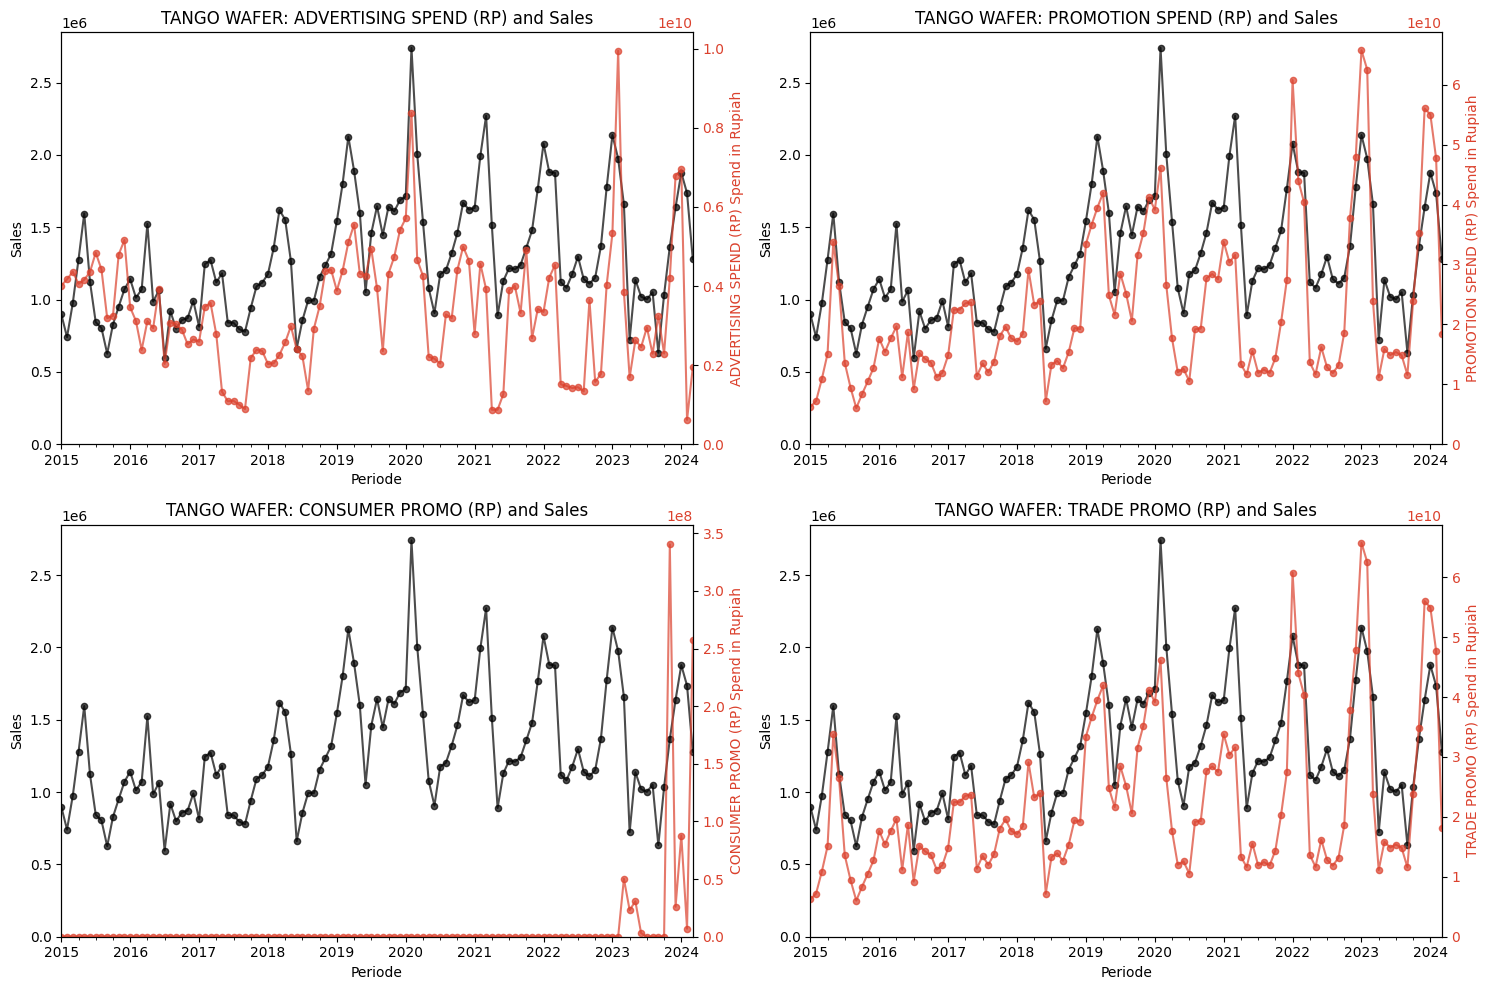

In [4]:
import matplotlib.pyplot as plt

def dual_y_axis_plot(data1, data2, kp, external_feature, target, ax):
    # Plot the first set of data
    color = 'black'
    data1['df'].plot(x=data1['x'], y=data1['y'], color=color, alpha=0.7, title="{}: {} and {}".format(kp, external_feature, target), ax=ax)
    data1['df'].plot(kind='scatter', x=data1['x'], y=data1['y'], color=color, alpha=0.7, title="{}: {} and {}".format(kp, external_feature, target), legend=False, ax=ax)
    
    # Customize the first y-axis
    ax.set_xlabel(data1['xlabel'])
    ax.set_ylabel(data1['ylabel'], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.get_legend().remove()
    ax.set_ylim(0)

    # Create a second y-axis that shares the same x-axis
    ax_twin = ax.twinx()
    
    # Plot the second set of data
    color = '#db412d'
    data2['df'].plot(x=data2['x'], y=data2['y'], color=color, alpha=0.7, ax=ax_twin)
    data2['df'].plot(kind='scatter', x=data2['x'], y=data2['y'], color=color, alpha=0.7, legend=False, ax=ax_twin)
    
    # Customize the second y-axis
    ax_twin.set_ylabel(data2['ylabel'], color=color)
    ax_twin.tick_params(axis='y', labelcolor=color)
    ax_twin.get_legend().remove()
    ax_twin.set_ylim(0)

import matplotlib.pyplot as plt
from itertools import product


# sg_formula_df = sg_formula_df[['Periode', 'KP', 'Sales', 'ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'CONSUMER PROMO (RP)', 'TRADE PROMO (RP)', 'TARPS FORMULA']]

kp_and_external_features = {
    "CRYSTALIN": ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'CONSUMER PROMO (RP)', 'TRADE PROMO (RP)', 'TARPS CRYSTALIN'],
    "TEH GELAS CUP": ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'CONSUMER PROMO (RP)', 'TRADE PROMO (RP)', 'TARPS TEH GELAS'],
    "KIRANTI": ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'CONSUMER PROMO (RP)', 'TRADE PROMO (RP)', 'TARPS KIRANTI'],
    "SG FORMULA": ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'CONSUMER PROMO (RP)', 'TRADE PROMO (RP)', 'TARPS FORMULA'],
    "TANGO WAFER": ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'CONSUMER PROMO (RP)', 'TRADE PROMO (RP)']
}
target = 'Sales'
for kp, external_features in kp_and_external_features.items():
    nrows = int(np.ceil(len(external_features) / 2))
    fig, ax = plt.subplots(nrows, 2, figsize=(15, nrows*5))
    for external_feature, (i, j) in zip(external_features, product(range(nrows), range(2))):
        data1 = {
            'df': preprocessed_omset_df[preprocessed_omset_df['KP']==kp],
            'x': 'Periode',
            'y': 'Sales',
            'xlabel': 'Periode',
            'ylabel': target
        }

        data2 = {
            'df': preprocessed_aa_graph_df[
                (preprocessed_aa_graph_df['KP']==kp) 
                & (preprocessed_aa_graph_df['Dimensi']==external_feature)
            ],
            'x': 'Periode',
            'y': 'Value',
            'ylabel': '{} Spend in Rupiah'.format(external_feature)
        }
        dual_y_axis_plot(data1, data2, kp, external_feature, target, ax=ax[i, j])
    plt.tight_layout()
    plt.show()

# Market Mix Modelling Tango

In [23]:
kp = 'CRYSTALIN'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)', 'TARPS CRYSTALIN']

# Data for statsforecast modelling
tango_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_df = tango_df[['Periode', 'KP', 'Sales']+exog_columns]

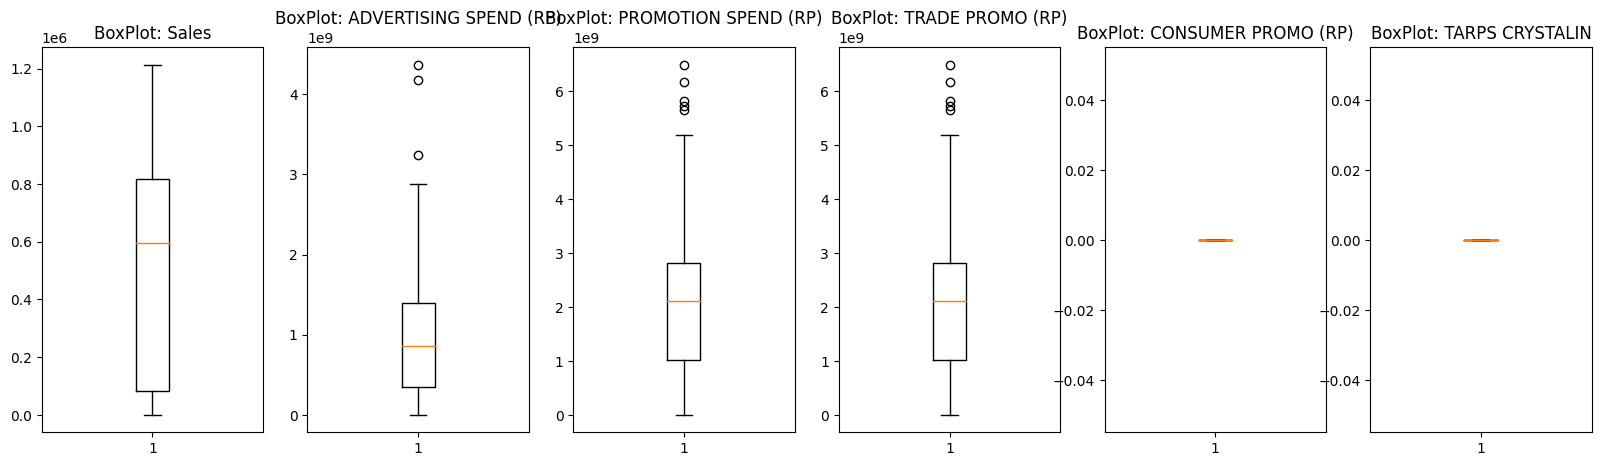

In [24]:
# Identify outliers
fig, ax = plt.subplots(ncols=len(['Sales']+exog_columns), figsize=(20, 5))
for idx, col in enumerate(['Sales']+exog_columns):
    ax[idx].boxplot(tango_df[col])
    ax[idx].set_title("BoxPlot: {}".format(col))
plt.show()

# Exploratory Data Analysis

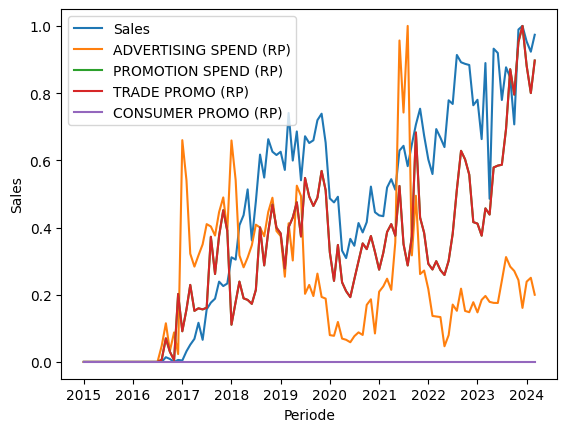

In [25]:
from sklearn.preprocessing import MinMaxScaler
tango_df_scaled = tango_df.copy()
scaler = MinMaxScaler()
tango_df_scaled[['Sales']+exog_columns] = scaler.fit_transform(tango_df_scaled[['Sales']+exog_columns]) 
sns.lineplot(data=tango_df_scaled, x='Periode', y='Sales', label='Sales')
sns.lineplot(data=tango_df_scaled, x='Periode', y='ADVERTISING SPEND (RP)', label='ADVERTISING SPEND (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='PROMOTION SPEND (RP)', label='PROMOTION SPEND (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='TRADE PROMO (RP)', label='TRADE PROMO (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='CONSUMER PROMO (RP)', label='CONSUMER PROMO (RP)')
plt.legend()

## Plot Linear Regression Line

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/awmarcel/miniconda3/envs/revenue-forecasting/lib/python3.10/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

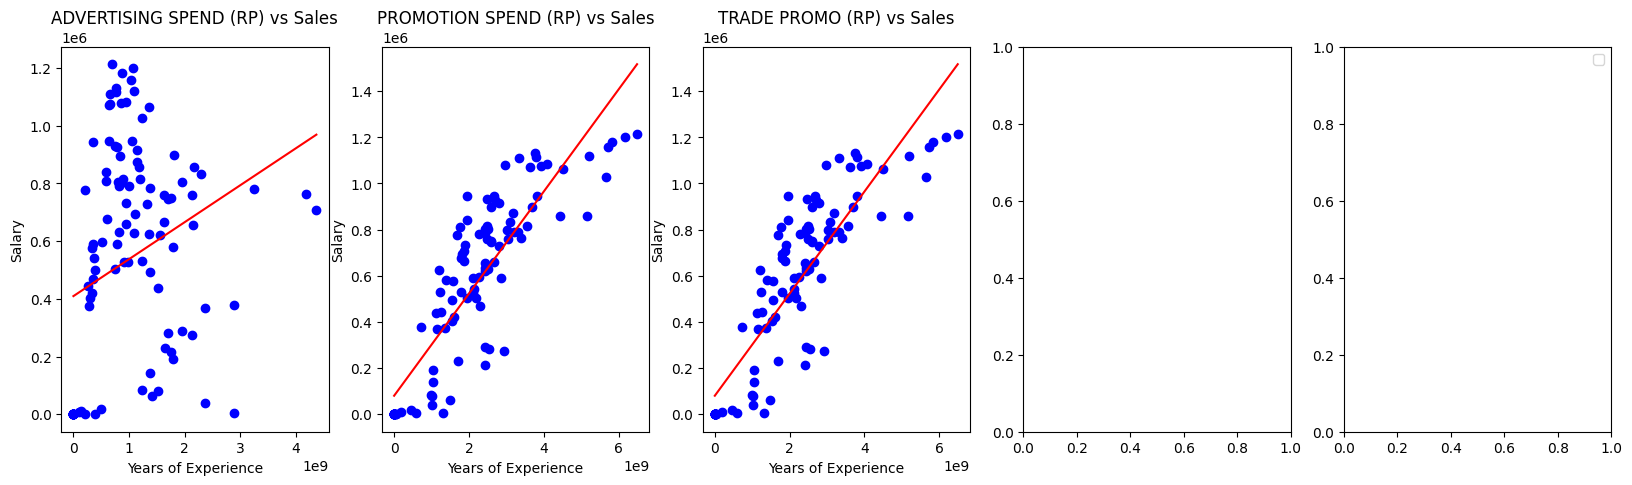

In [26]:
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(ncols=len(exog_columns), figsize=(20, 5))

for idx, col in enumerate(exog_columns):
    # Step 1: Generate some sample data
    x = tango_df[col].to_numpy()
    y = tango_df['Sales'].to_numpy()

    # Step 1: Normalize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_normalized = scaler_x.fit_transform(x.reshape(-1, 1)).flatten()
    y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Step 2: Fit a quadratic polynomial to the normalized data
    coefficients = np.polyfit(x_normalized, y_normalized, 1)
    quadratic_trendline = np.poly1d(coefficients)

    # Step 3: Generate y values for the trendline
    x_sorted = np.sort(x_normalized)
    y_trend = quadratic_trendline(x_sorted)

    # Step 4: Inverse transform the trendline values to original scale
    x_sorted_original = scaler_x.inverse_transform(x_sorted.reshape(-1, 1)).flatten()
    y_trend_original = scaler_y.inverse_transform(y_trend.reshape(-1, 1)).flatten()

    # Step 5: Plot the scatter plot and the quadratic trendline
    ax[idx].scatter(x, y, label='Data points', color='blue')
    ax[idx].plot(x_sorted_original, y_trend_original, color='red', label='Quadratic trendline')
    ax[idx].set_xlabel('Years of Experience')
    ax[idx].set_ylabel('Salary')
    ax[idx].set_title("{} vs Sales".format(col))
    plt.legend()
plt.show()

## Plot Polynomial Linear Regression Line

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/home/awmarcel/miniconda3/envs/revenue-forecasting/lib/python3.10/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

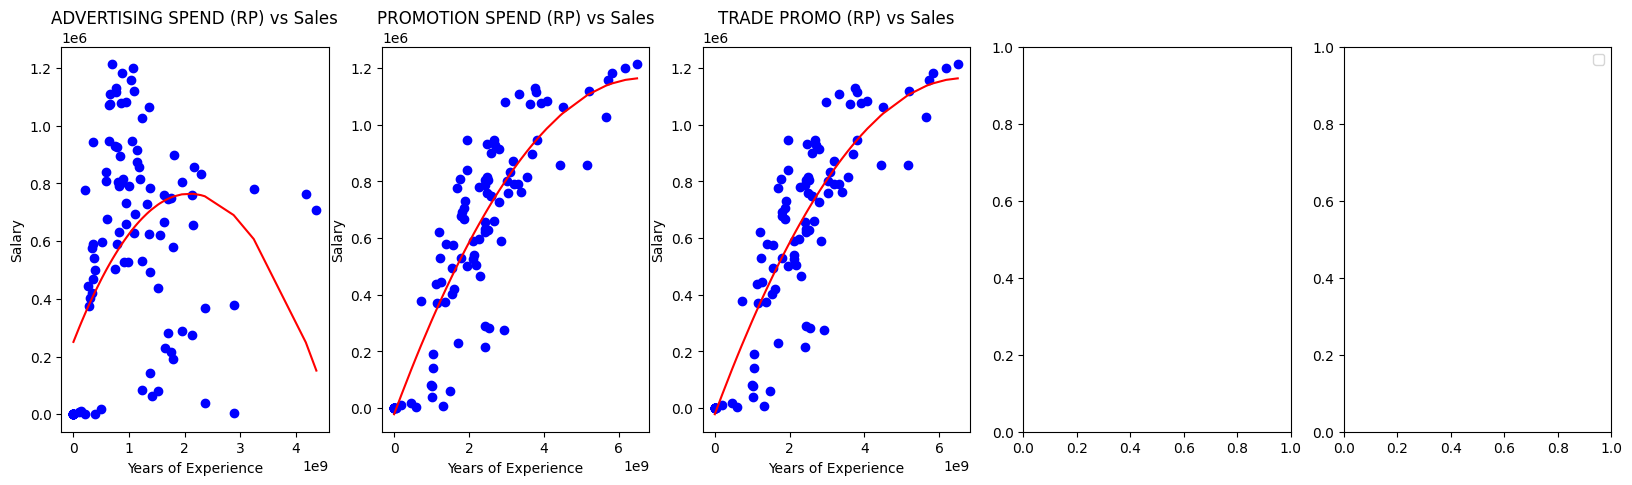

In [27]:
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(ncols=len(exog_columns), figsize=(20, 5))

for idx, col in enumerate(exog_columns):
    # Step 1: Generate some sample data
    x = tango_df[col].to_numpy()
    y = tango_df['Sales'].to_numpy()

    # Step 1: Normalize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_normalized = scaler_x.fit_transform(x.reshape(-1, 1)).flatten()
    y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Step 2: Fit a quadratic polynomial to the normalized data
    coefficients = np.polyfit(x_normalized, y_normalized, 2)
    quadratic_trendline = np.poly1d(coefficients)

    # Step 3: Generate y values for the trendline
    x_sorted = np.sort(x_normalized)
    y_trend = quadratic_trendline(x_sorted)

    # Step 4: Inverse transform the trendline values to original scale
    x_sorted_original = scaler_x.inverse_transform(x_sorted.reshape(-1, 1)).flatten()
    y_trend_original = scaler_y.inverse_transform(y_trend.reshape(-1, 1)).flatten()

    # Step 5: Plot the scatter plot and the quadratic trendline
    ax[idx].scatter(x, y, label='Data points', color='blue')
    ax[idx].plot(x_sorted_original, y_trend_original, color='red', label='Quadratic trendline')
    ax[idx].set_xlabel('Years of Experience')
    ax[idx].set_ylabel('Salary')
    ax[idx].set_title("{} vs Sales".format(col))
    plt.legend()
plt.show()

## Pearson Correlation

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


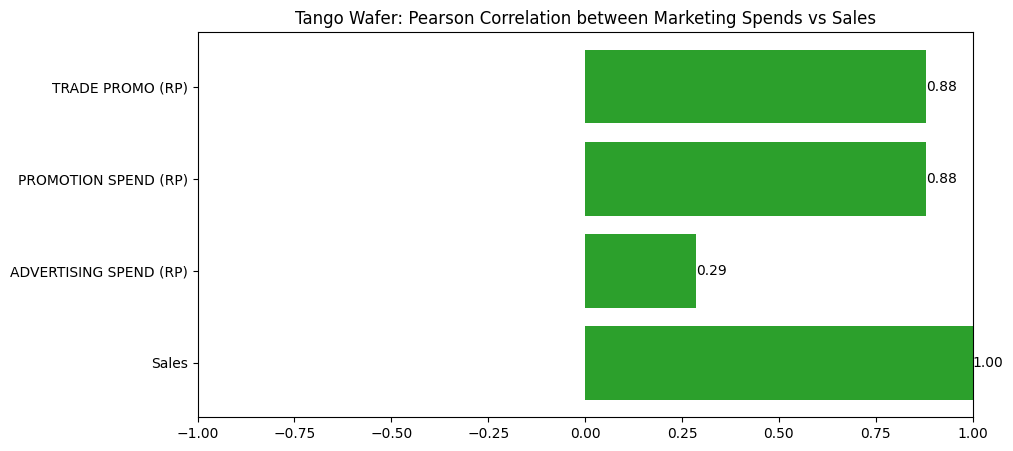

In [28]:
def plot_correlation_coefficient(data, title):
    plt.figure(figsize=(10, 5))
    colors = ['tab:green' if value >= 0 else 'tab:red' for value in data.values]
        # Create the horizontal bar plot
    bars = plt.barh(data.index, data.values, color=colors)
    
    # Add annotations
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width+0.04, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
                 ha='center', va='center', color='black', fontsize=10)
        else: 
            plt.text(width-0.04, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
                 ha='center', va='center', color='black', fontsize=10)
    plt.title(title)
    plt.xlim([-1, 1])
    plt.show()

plot_correlation_coefficient(tango_df[['Sales']+exog_columns].corr()['Sales'], "Tango Wafer: Pearson Correlation between Marketing Spends vs Sales")
plt.show()

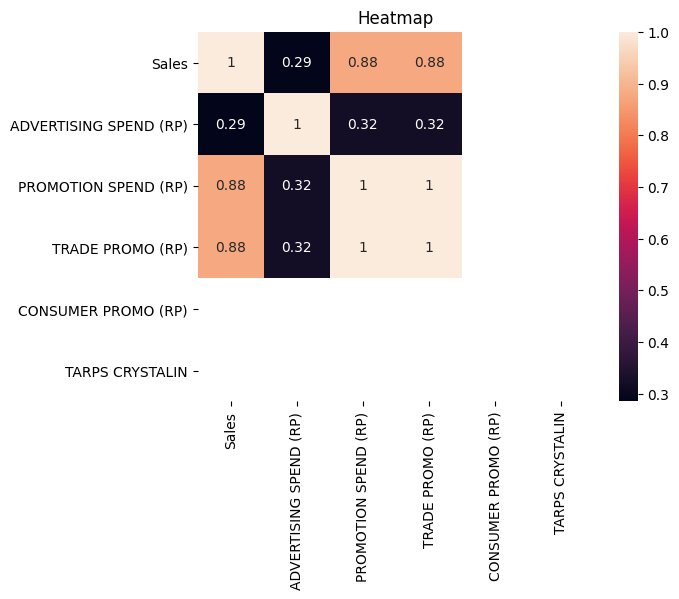

In [29]:
sns.heatmap(tango_df[['Sales']+exog_columns].corr(), annot=True)
plt.title("Heatmap")
plt.show()

# Modelling

In [40]:
from sklearn.model_selection import train_test_split

features = ['CONSUMER PROMO (RP)', 'ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)']
target = 'Sales'

# Data for statsforecast modelling
X, y = tango_df[features], tango_df[target].tolist()

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=42, test_size=0.2)

## Model Baseline with Linear Regression

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Features and targets
features = ['CONSUMER PROMO (RP)', 'ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)']
target = 'Sales'


# Standardized features
scaler = MinMaxScaler()
X_train_preprocessed = X_train.copy() 
X_train_preprocessed[features] = np.log1p(X_train_preprocessed[features]) 
X_train_preprocessed[features] = scaler.fit_transform(X_train_preprocessed[features])
X_test_preprocessed = X_test.copy() 
X_test_preprocessed[features] = np.log1p(X_test_preprocessed[features]) 
X_test_preprocessed[features] = scaler.transform(X_test_preprocessed[features])

# Prepare Model
lr = LinearRegression()

# Train
lr.fit(X_train_preprocessed, y_train)

# Evaluation
print("Train MAPE: {}".format(mean_absolute_percentage_error(y_train, lr.predict(X_train_preprocessed))))
print("Train R2: {}".format(r2_score(y_train, lr.predict(X_train_preprocessed))))
print()
print("Test MAPE: {}".format(mean_absolute_percentage_error(y_test, lr.predict(X_test_preprocessed))))
print("Test R2: {}".format(r2_score(y_test, lr.predict(X_test_preprocessed))))

Train MAPE: 2.6768528208534794e+19
Train R2: 0.5655626007950313

Test MAPE: 0.33442001833976964
Test R2: -5.1903404285882795


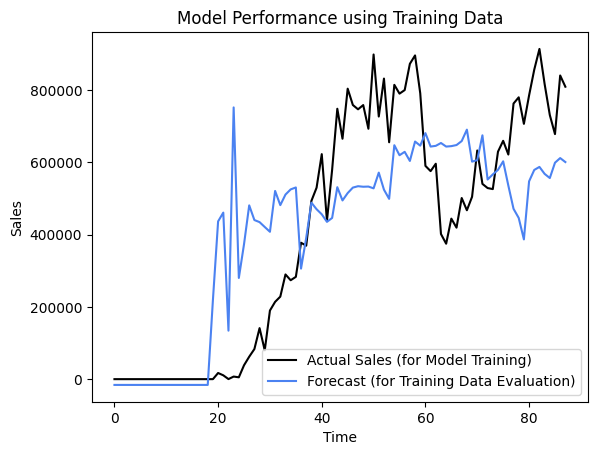

In [42]:
color = {
    'black': 'black', 
    'google_red': '#db412d', 
    'google_blue': '#4b82f1'
}
plt.plot(y_train, label="Actual Sales (for Model Training)", color=color["black"])
plt.plot(lr.predict(X_train_preprocessed), label="Forecast (for Training Data Evaluation)", color=color["google_blue"])
plt.legend()
plt.title("Model Performance using Training Data")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

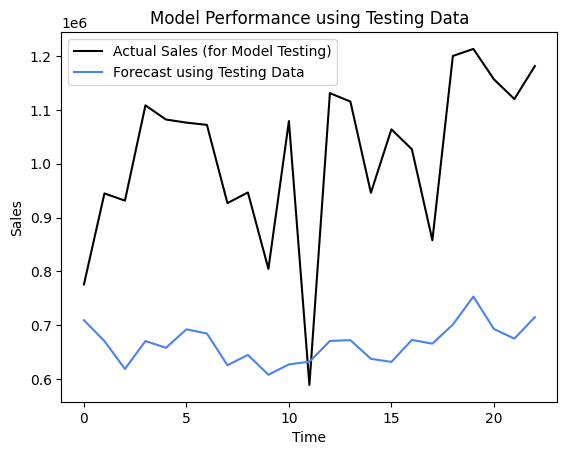

In [43]:
color = {
    'black': 'black', 
    'google_red': '#db412d', 
    'google_blue': '#4b82f1'
}
plt.plot(y_test, label="Actual Sales (for Model Testing)", color=color["black"])
plt.plot(lr.predict(X_test_preprocessed), label="Forecast using Testing Data", color=color["google_blue"])
plt.legend()
plt.title("Model Performance using Testing Data")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

In [44]:
print("Intercept(s)\t: {}".format(lr.intercept_))
for feature, coef in zip(lr.feature_names_in_, lr.coef_):
    print("{}\t: {}".format(feature, coef))

Intercept(s)	: -15980.473651764914
CONSUMER PROMO (RP)	: 0.0
ADVERTISING SPEND (RP)	: -2433959.8042592523
PROMOTION SPEND (RP)	: 1476011.2062009112
TRADE PROMO (RP)	: 1476011.2062009107


### Interpretation
In accordance to the Pearson Correlation:
- The highest drive to Tango Wafer Sales is **PROMOTION SPEND (RP)** and **TRADE PROMO (RP)**. Followed by **ADVERTISING SPEND (RP)**
- Vase sales will be `362714` if the management didn't spend anything on marketing. 

# Modelling with LightweightMMM
Is a model based on Bayesian Approach, using the previous iteration data.
It comprises of:
1. base sales
2. trend
3. seasonality
4. media channels (media to promote product)
5. other factors (promo, holiday, item price)

Media saturation is an important variable to simulate how media influence to the sales saturated overtime. There are 3 methods:
1. Adstock
2. Hill-Adstock
3. Carryover





Flow
![flow of the lightweightmmm modelling](../reports/figures/flowchart.png)

### Data preparation using scaling

In [84]:
# %reload_ext autoreload
# %autoreload 2

import jax.numpy as jnp
import numpyro

In [85]:
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

In [86]:
kp = 'TANGO WAFER'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)']

# Data for statsforecast modelling
tango_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_df = tango_df[['Periode', 'KP', 'Sales']+exog_columns]

In [134]:
data_size = len(tango_df)
# Split and scale data.
split_point = data_size - 13

# Media data
media_data = media_data = tango_df[['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)']].to_numpy()
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]

# Extra features
extra_features = tango_df[
    ['TRADE PROMO (RP)']
].to_numpy()
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]

# Target
target = tango_df['Sales'].to_numpy()
target_train = target[:split_point]

# Costs
costs = tango_df[['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)']].sum().to_numpy()

In [135]:
# Data preprocessing
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [143]:
# Marketing Mix Modelling
mmm = lightweight_mmm.LightweightMMM(model_name="adstock")
mmm.fit(media=media_data_train,
        extra_features=extra_features_train,
        media_prior=costs,
        target=target_train,
        number_warmup=1000,
        number_samples=1000,
        number_chains=2)

/home/awmarcel/miniconda3/envs/revenue-forecasting/lib/python3.10/site-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(


TypeError: where() got some positional-only arguments passed as keyword arguments: 'condition, x, y'

In [56]:
data_size = 104
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size + 13,
    n_media_channels=3,
    n_extra_features=1)
costs

Array([234.9729, 235.9593, 233.8534], dtype=float32)

In [60]:
media_data.sum(0)/10

Array([234.9729, 235.9593, 233.8534], dtype=float32)

In [55]:
np.mean(media_data, axis=0)

Array([20.083155, 20.167463, 19.98747 ], dtype=float32)

array([[4.01223280e+09, 6.23976956e+09],
       [4.16820746e+09, 7.21149015e+09],
       [4.36333275e+09, 1.08709904e+10],
       [4.05687953e+09, 1.51003318e+10],
       [4.15870308e+09, 3.37552902e+10],
       [4.35647066e+09, 2.64427035e+10],
       [4.84368628e+09, 1.35706231e+10],
       [4.41991648e+09, 9.46285031e+09],
       [3.18772308e+09, 6.03249459e+09],
       [3.24675603e+09, 8.33562042e+09],
       [4.79556983e+09, 1.04854537e+10],
       [5.16388109e+09, 1.27276763e+10],
       [3.46213464e+09, 1.76284030e+10],
       [3.11884009e+09, 1.54022667e+10],
       [2.38490394e+09, 1.76466233e+10],
       [3.11632008e+09, 1.96626256e+10],
       [2.93525380e+09, 1.11946752e+10],
       [3.92632248e+09, 1.86639684e+10],
       [2.03088197e+09, 9.20539471e+09],
       [3.07789151e+09, 1.52101442e+10],
       [3.04137054e+09, 1.42332982e+10],
       [2.90081202e+09, 1.36230584e+10],
       [2.52888556e+09, 1.12112551e+10],
       [2.64941327e+09, 1.19210564e+10],
       [2.592556

In [33]:
costs

Array([234.9729, 235.9593, 233.8534], dtype=float32)

In [63]:
media_data[:, :].sum(axis=0)

Array([2349.729, 2359.593, 2338.534], dtype=float32)

In [61]:
media_data.shape

(117, 3)

In [114]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=160,
    n_media_channels=3,
    n_extra_features=2,
    geos=1) # Or geos=1 for national model

In [116]:
print(media_data.shape)
print(extra_features.shape)
print(target.shape)
print(costs.shape)

(160, 3)
(160, 2)
(160,)
(3,)


In [127]:
costs

Array([320.16287, 315.1931 , 319.34937], dtype=float32)

In [124]:
media_data_train

Array([[1.195076  , 0.28847083],
       [1.2415344 , 0.33339444],
       [1.299654  , 0.5025768 ],
       [1.2083745 , 0.69810355],
       [1.2387034 , 1.560541  ],
       [1.2976102 , 1.2224728 ],
       [1.4427313 , 0.6273836 ],
       [1.3165079 , 0.4374771 ],
       [0.9494891 , 0.2788883 ],
       [0.9670726 , 0.38536412],
       [1.4283993 , 0.48475307],
       [1.5381038 , 0.58841324],
       [1.0312248 , 0.81497884],
       [0.92897177, 0.7120623 ],
       [0.710363  , 0.8158211 ],
       [0.92822117, 0.9090229 ],
       [0.8742891 , 0.5175411 ],
       [1.169487  , 0.86285406],
       [0.60491467, 0.42557463],
       [0.9167749 , 0.70318025],
       [0.9058969 , 0.65801966],
       [0.86403036, 0.6298077 ],
       [0.75324905, 0.51830757],
       [0.7891492 , 0.5511224 ],
       [0.77221406, 0.685598  ],
       [1.0351846 , 1.0385739 ],
       [1.0639443 , 1.0375936 ],
       [0.82793266, 1.0870801 ],
       [0.39511606, 1.0934947 ],
       [0.3237622 , 0.52485836],
       [0.

In [123]:
target_train.shape

(98,)